In [148]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [149]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [150]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [151]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
print(engine)

Engine(sqlite:///Resources/hawaii.sqlite)


In [152]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine, reflect=True)


# reflect the tables
class_names = sorted(Base.classes.keys())


/var/folders/c9/whb3jh8n0sz1zw9tjll5y44r0000gn/T/ipykernel_1416/4086494929.py:3: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [153]:
# View all of the classes that automap found
class_names = sorted(Base.classes.keys())
class_names


['measurement', 'station']

In [154]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [155]:
# Create our session (link) from Python to the DB
session = Session(engine)


# Exploratory Precipitation Analysis

In [156]:
# Find the most recent date in the data set.
latest_date = session.query(func.max(Measurement.date)).scalar()
latest_date=dt.datetime.strptime(latest_date, '%Y-%m-%d').date()
print(latest_date)



2017-08-23


One year ago from the latest date is: 2016-08-23


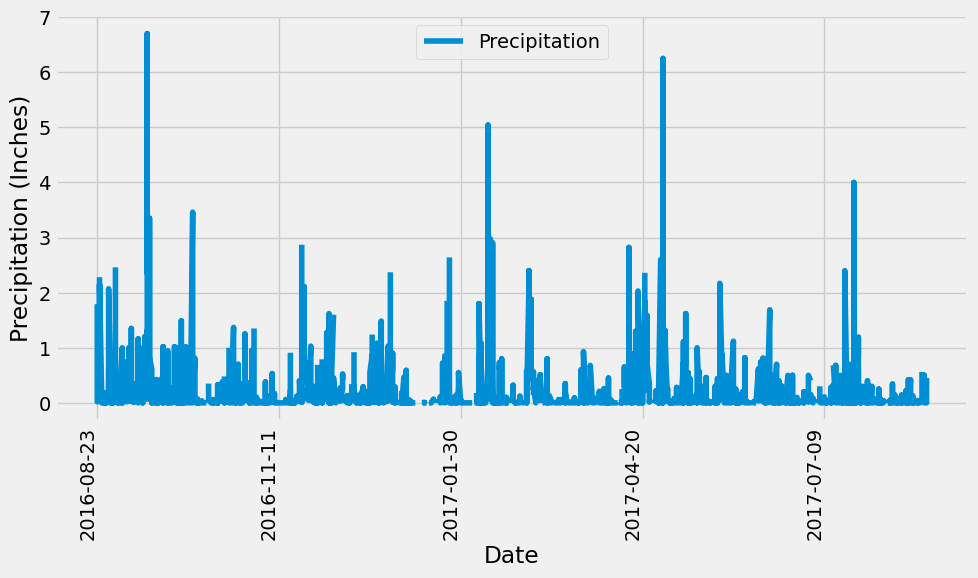

In [157]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.
date_one_year_ago=latest_date - dt.timedelta(days=365)
print(f"One year ago from the latest date is: {date_one_year_ago}")



# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= date_one_year_ago).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precip_data_df=pd.DataFrame(precipitation_data,columns=['date','prcp'])

# Sort the dataframe by date
precip_data_df.sort_values(by='date',inplace=True)
# precip_data_df.set_index('date',inplace=True)


plt.figure(figsize=(10, 6))
plt.plot(precip_data_df['date'], precip_data_df['prcp'], label='Precipitation')
plt.xlabel("Date")
plt.ylabel("Precipitation (Inches)")
plt.xticks(rotation=90, ha='right')  # Rotate labels by 90 degrees and align them
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(6))  # Set maximum number of ticks to 6
plt.legend(['Precipitation'], loc='upper center')
plt.tight_layout()
plt.show()


In [158]:
# Use Pandas to calculate the summary statistics for the precipitation data
stat=precip_data_df.describe()
stat_df=pd.DataFrame(stat)
stat_df

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [159]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).scalar()
print(f"The total number of stations in the dataset is: {total_stations}")


The total number of stations in the dataset is: 9


In [160]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()
active_stations


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [161]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = active_stations[0][0]
lowest_temperature=session.query(func.min(Measurement.tobs)).filter(Measurement.station==most_active_station).scalar()
highest_temperature=session.query(func.max(Measurement.tobs)).filter(Measurement.station==most_active_station).scalar()
average_temperature=session.query(func.avg(Measurement.tobs)).filter(Measurement.station==most_active_station).scalar()

print(f"The lowest temperature for most active stations {most_active_station}: {lowest_temperature}")
print(f"The highest temperature for most active stations {most_active_station}: {highest_temperature}")
print(f"The average temperature for most active stations {most_active_station}: {average_temperature:.2f}")



The lowest temperature for most active stations USC00519281: 54.0
The highest temperature for most active stations USC00519281: 85.0
The average temperature for most active stations USC00519281: 71.66


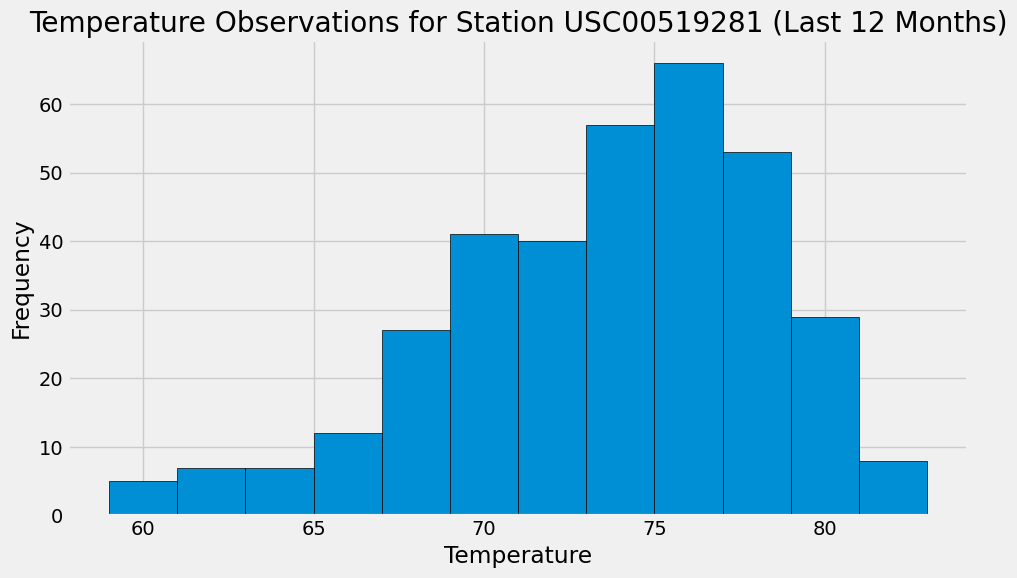

In [162]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


temp_data = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == most_active_station).\
    filter(Measurement.date >= date_one_year_ago).all()

temp_data_df=pd.DataFrame(temp_data)


plt.figure(figsize=(10, 6))
plt.hist(temp_data_df['tobs'], bins=12, edgecolor='black')
plt.title(f'Temperature Observations for Station {most_active_station} (Last 12 Months)')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Close Session

In [163]:
# Close Session
session.close()